In [46]:
import pandas as pd
import numpy as np
import riskfolio as rf
import yfinance as yf
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('yf_df.csv')
df.set_index('Date', inplace = True)
df

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-11,8601.795898,185.912842,0.194064,0.002413,3.585065
2020-05-12,8804.477539,189.312500,0.197637,0.002463,3.692374
2020-05-13,9269.987305,199.193283,0.201480,0.002521,3.760424
2020-05-14,9733.721680,202.949097,0.203129,0.002574,3.799387
2020-05-15,9328.197266,195.622665,0.198911,0.002506,3.674653
...,...,...,...,...,...
2024-05-16,65231.582031,2945.131104,0.515698,0.149637,15.509692
2024-05-17,67051.875000,3094.118652,0.523804,0.155563,16.252932
2024-05-18,66940.804688,3122.948975,0.521390,0.153077,16.311008


In [31]:
benchmark = yf.download('^GSPC', start = '2020-05-11', end = '2024-05-21')
benchmark = benchmark[('Adj Close')]
benchmark

[*********************100%%**********************]  1 of 1 completed


/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


Date
2020-05-11    2930.189941
2020-05-12    2870.120117
2020-05-13    2820.000000
2020-05-14    2852.500000
2020-05-15    2863.699951
                 ...     
2024-05-14    5246.680176
2024-05-15    5308.149902
2024-05-16    5297.100098
2024-05-17    5303.270020
2024-05-20    5308.129883
Name: Adj Close, Length: 1014, dtype: float64

In [32]:
#Get returns
returns = df.pct_change().dropna() #Overall returns for each asset
returns_bench = benchmark.pct_change().dropna()

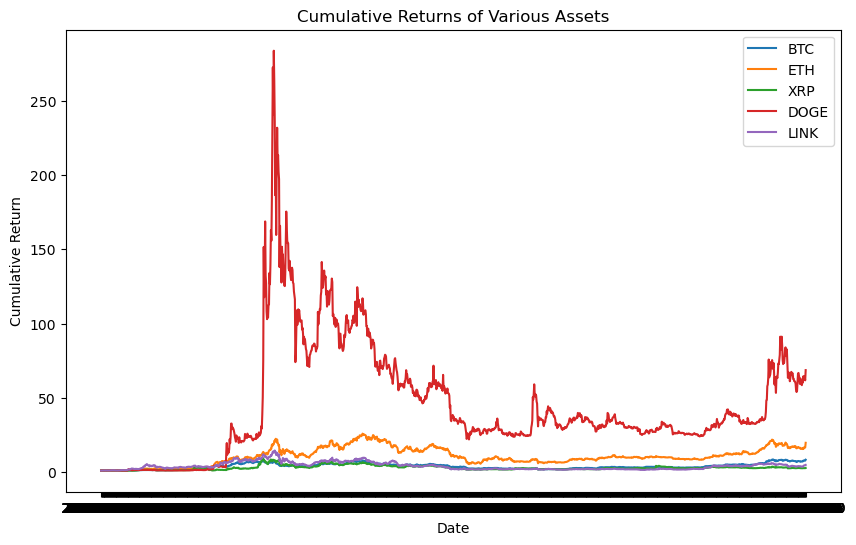

In [47]:
# Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(10, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

# Add title and labels
plt.title('Cumulative Returns of Various Assets')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

plt.show()

In [34]:
returns_bench

Date
2020-05-12   -0.020500
2020-05-13   -0.017463
2020-05-14    0.011525
2020-05-15    0.003926
2020-05-18    0.031501
                ...   
2024-05-14    0.004838
2024-05-15    0.011716
2024-05-16   -0.002082
2024-05-17    0.001165
2024-05-20    0.000916
Name: Adj Close, Length: 1013, dtype: float64

In [35]:
#Building portfolio object
port = rf.Portfolio(returns, nea = 4)

port.assets_stats(
    method_mu = 'hist', #Selected method to estimate expected returns based on historical data
    method_cov = 'hist', #Selected method to estimate covariance matrix based on historical data
    d = 0.94)

port.benchindex = returns_bench

In [36]:
#Estimate optimal portfolio for mean/cvar ratio
w = port.optimization(
    model = 'Classic', #Either classic, BL(Black Litterman), FM(Factor model), BLFM(Black Litterman w/Factor models)
    rm = 'CVaR', #Risk measure
    obj = 'Sharpe', #Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True, #Use historical scenarios for risk measures
    rf = 0, #Risk free rate
    l = 0) #Risk aversion factor, only useful when obj is 'utility'
w #Optimal weights for our portfolio

,weights
BTC,0.182915
ETH,0.197019
XRP,0.140741
DOGE,0.386362
LINK,0.092963


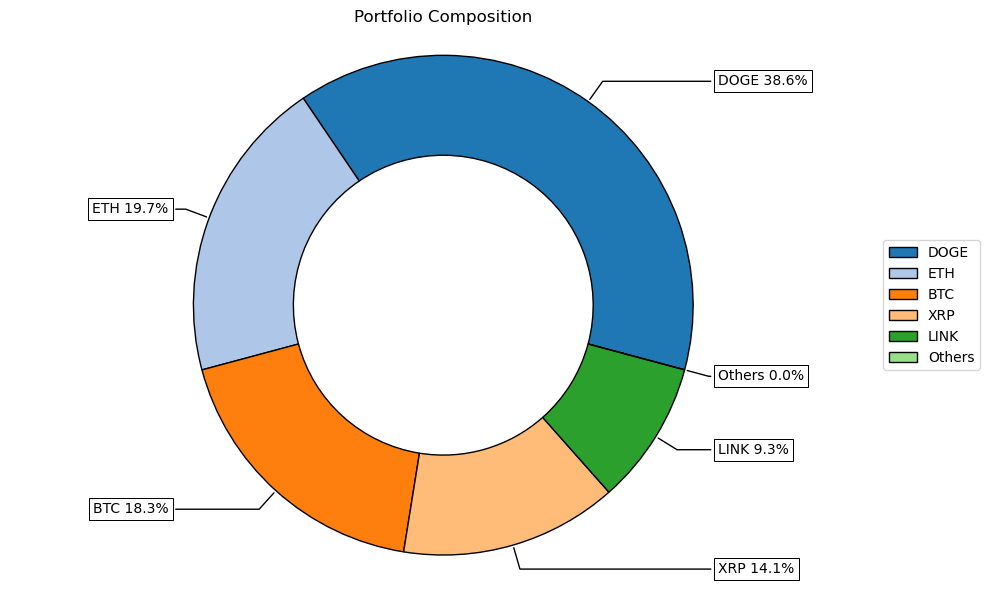

In [37]:
#Plotting optimal portfolio composition
ax = rf.plot_pie(
    w = w,
    others = 0.05,
    nrow = 25,
    cmap = 'tab20',
    height = 6,
    width = 10,
    ax = None)

In [38]:
#Calculate efficient frontier
points = 50

frontier = port.efficient_frontier(model = 'Classic',
                                   rm = 'CVaR',
                                   rf = 0,
                                   hist = True)

display(frontier.T.head())

,BTC,ETH,XRP,DOGE,LINK
0,0.367795,0.237384,0.186109,0.135650,0.073061
1,0.350658,0.240567,0.156395,0.206375,0.046005
2,0.338687,0.237021,0.148159,0.235628,0.040505
3,0.325511,0.235363,0.142132,0.258821,0.038173
4,0.312488,0.234800,0.135690,0.278004,0.039018


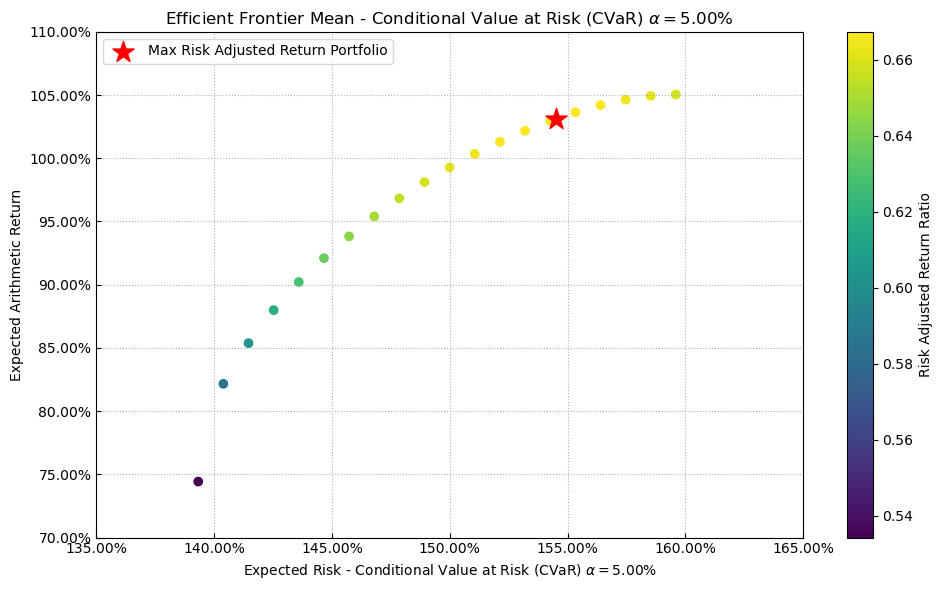

In [39]:
#Plot efficient frontier

ax = rf.plot_frontier(w_frontier = frontier,
                      mu = port.mu,
                      cov = port.cov,
                      returns = port.returns,
                      rm = 'CVaR',
                      rf = 0,
                      alpha = 0.05,
                      cmap = 'viridis',
                      w = w,
                      label = 'Max Risk Adjusted Return Portfolio',
                      marker = '*',
                      s = 16,
                      c = 'r',
                      height = 6,
                      width = 10,
                      ax = None
                      )

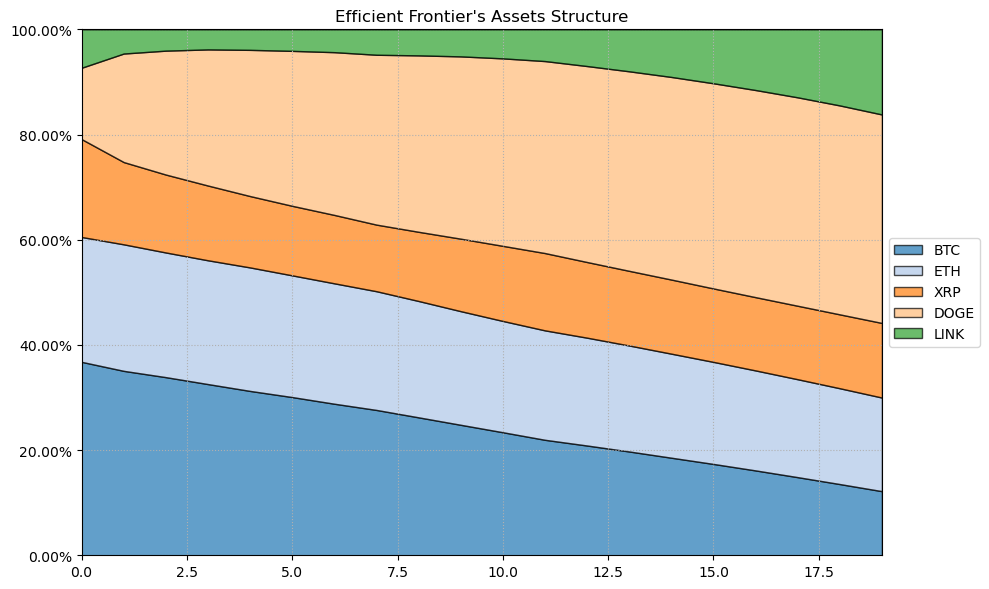

In [40]:
#Plot efficient frontier composition

ax = rf.plot_frontier_area(w_frontier = frontier,
                           cmap = 'tab20',
                           n_colors = 20,
                           height = 6,
                           width = 10,
                           ax = None)

<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>

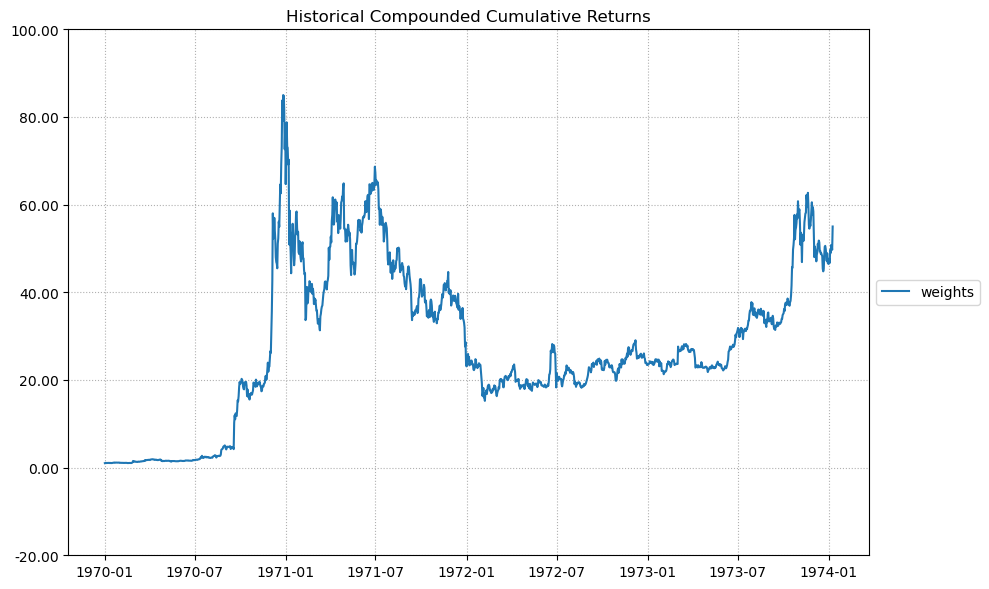

In [41]:
#Compounded returns
rf.plot_series(returns = returns, w = w)

array([<Axes: title={'center': 'Historical Compounded Cumulative Returns'}>,
       <Axes: title={'center': 'Historical Uncompounded Drawdown'}>],
      dtype=object)

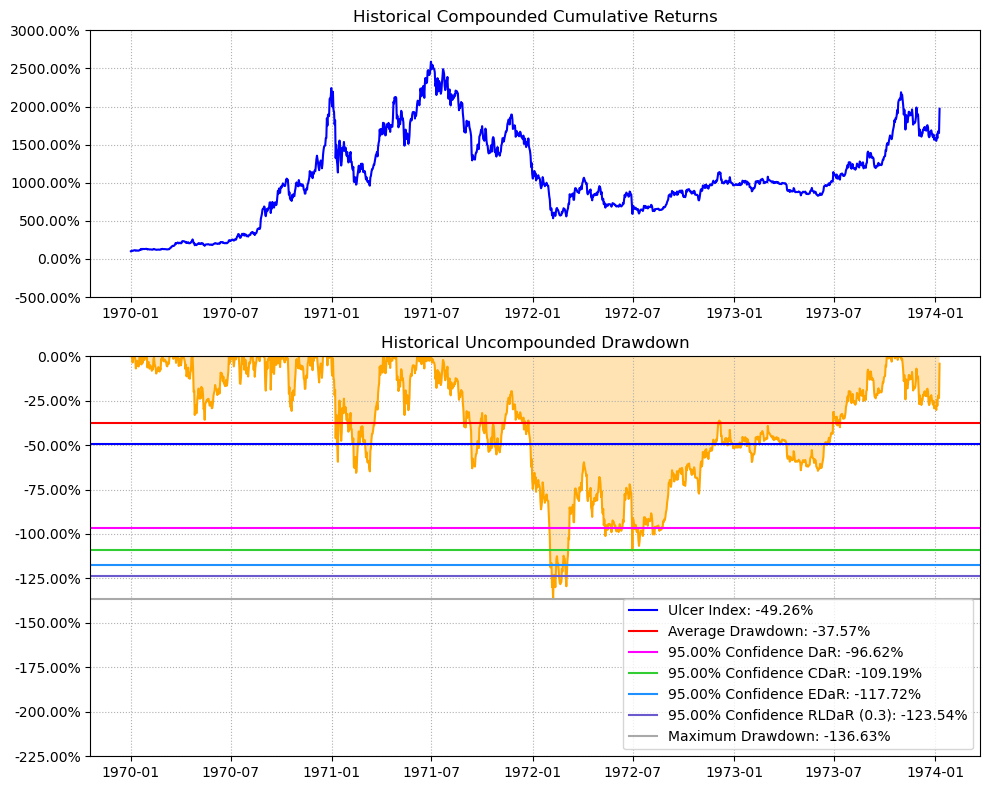

In [26]:
#Compounded returns + max drawdown
rf.plot_drawdown(returns, w = w)